In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 
EPOCHS_BASE = 50 #or 100
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
folder = "./AirlineSentiment/"
label_names = ["positive","neutral","negative"]

label_names = label_names[:2]
label_names += ['badflight', 'CSProblem', 'canttell', 'late', 'airplanestaff',
       'booking', 'lostluggae', 'cancel', 'damagedluggage', 'longlines']

### Load Data and preprocess

In [4]:
import re
FLAGS = re.MULTILINE | re.DOTALL
def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps>"
def tokenize(text):
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"<3","<heart>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    text = re_sub(r"#\S+", "<hashtag>")
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

    ## -- I just don't understand why the Ruby script adds <allcaps> to everything so I limited the selection.
    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    text = re_sub(r"([A-Z]){2,}", allcaps)
    return text.lower()

def read_texts(filename):
    f = open(filename)
    data = [line.strip() for line in f]
    f.close()
    return data

texts_train = [tokenize(text) for text in read_texts(folder+"texts_train_.txt")]
#texts_test = [tokenize(text) for text in read_texts(folder+"texts_test.txt")]

#Z_train = np.loadtxt(folder+"sent_train.txt", dtype='int')
Z_train = np.loadtxt(folder+"sent_train_detail.txt", dtype='int')

#Z_test = np.loadtxt(folder+"sent_test.txt", dtype='int')

mask_gt = Z_train != -1
print("Num. train texts: %d" % len(texts_train))
#print("Num. test texts:  %d" % len(texts_test))

Num. train texts: 14680


In [5]:
folder_test = "./Sentiment/Semeval/"
texts_test = [tokenize(text) for text in read_texts(folder_test+"texts_data.txt")]

Z_test = np.loadtxt(folder_test+"sent_data.txt", dtype='int')

mask_data = Z_test <= 2
Z_test = Z_test[mask_data]
texts_test = list(np.asarray(texts_test)[mask_data])

print("Num. test texts:  %d" % len(texts_test))

Num. test texts:  3805


In [6]:
##mask Z_train to be test....
mask_gt = Z_train != -1

texts_test = list(np.asarray(texts_train)[mask_gt])
texts_train = list(np.asarray(texts_train)[~mask_gt])

Z_test = Z_train[mask_gt]
Z_train = Z_train[~mask_gt]

print("Num. train texts: %d" % len(texts_train))
print("Num. test texts:  %d" % len(texts_test))

Num. train texts: 14600
Num. test texts:  80


In [ ]:
## como tengo anotaciones en test podria utilizar para medir matrices de confusion "fuera" out of samplke

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(Z_test)
plt.xticks(np.arange(0,len(label_names)),label_names)
plt.show()

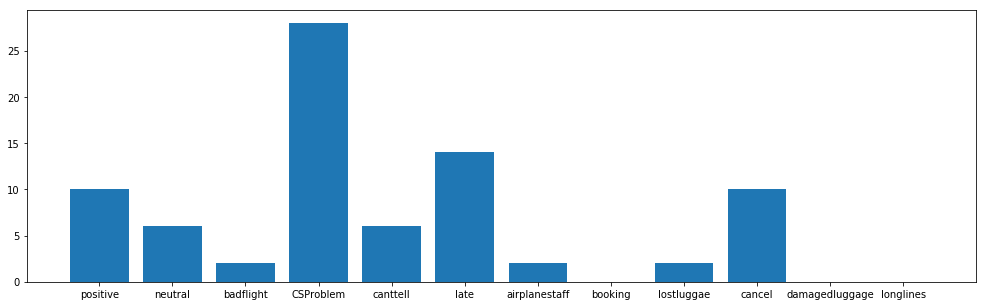

In [39]:
df = pd.DataFrame(Z_test)
#df.groupby('a').count()
aux = df.iloc[:,0].value_counts()

plot_v = []
for i in range(len(label_names)):
    if i not in aux:
        plot_v.append(0)
    else:
        plot_v.append(aux[i])
plt.figure(figsize=(17,5))
plt.bar(np.arange(0,len(label_names)), plot_v)
plt.xticks(np.arange(0,len(label_names)),label_names)
plt.show()

In [7]:
from keras import preprocessing
MAX_NB_WORDS = 15000
tokenizer = preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts_train+texts_test)
sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)
MAX_NB_WORDS = len(tokenizer.word_index)
print('Found %s unique tokens.' % len(tokenizer.word_index))

Found 10469 unique tokens.


In [8]:
lens = list(map(len,sequences_train))
max_L = np.max(lens)
print("Real max: ",max_L)

X_train = preprocessing.sequence.pad_sequences(sequences_train, maxlen=max_L,dtype='int32', value=0,padding='pre')
X_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=max_L,dtype='int32', value=0,padding='pre')
print('Shape of train tensor:', X_train.shape)

Real max:  50
Shape of train tensor: (14600, 50)


In [9]:
EMBEDDING_DIM = 100
#GLOVE_FILE = "../AUX_DATA/glove.twitter.27B/glove.twitter.27B.%dd.txt"%(EMBEDDING_DIM)
GLOVE_FILE = "../GLOVE/glove.twitter.27B.%dd.txt"%(EMBEDDING_DIM)

embeddings_index = {}
with open(GLOVE_FILE) as file:
    for line in file:
        values = line.split()
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[values[0]] = coefs
print('Preparing embedding matrix.')
sorted_x = sorted(tokenizer.word_counts.items(), key=lambda kv: kv[1], reverse=True)
vocab = {value[0]:tokenizer.word_index[value[0]] for i, value in enumerate(sorted_x) if i < MAX_NB_WORDS}
embedding_matrix = np.zeros((len(vocab)+1, EMBEDDING_DIM))
v=0
for word, i in vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector # words not found in embedding index will be all-zeros.
        v+=1
del embeddings_index, sorted_x, tokenizer
gc.collect()
print("Words found on glove: ",v)

Preparing embedding matrix.
Words found on glove:  9225


### Load annotations / Generate

In [10]:
from code.representation import *
from code.utils import *

In [11]:
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers_detail.txt", delimiter=' ', dtype='int16')

#put mask
y_obs = y_obs[~mask_gt]

T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs = y_obs[:,T_weights!=0]

T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N,T = y_obs.shape
Kl = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",Kl)

Loading AMT data...
Remove 109 annotators that do not annotate on this set 
Shape (data,annotators):  (14600, 394)
Classes:  12


In [ ]:
#generate conf matrix...
confe_matrix_R = np.zeros((T,Kl,Kl),dtype=DTYPE_OP) #rodrigues add epsilon here
for t in range(T):    
    for i in range(N):
        if y_obs[i,t] != -1:
            confe_matrix_R[t,Z_train[i],y_obs[i,t]] +=1
            
    mask_nan = confe_matrix_R[t,:,:].sum(axis=-1) == 0
    mean_replace = np.mean(confe_matrix_R[t,:,:][~mask_nan],axis=0)
    for value in np.arange(Kl)[mask_nan]:
        confe_matrix_R[t,value,:] =  1 #Rodrigues 1./K -- similar  to laplace smooth (prior 1)
    confe_matrix_R[t,:,:] = confe_matrix_R[t,:,:]/confe_matrix_R[t,:,:].sum(axis=-1,keepdims=True) #normalize
confe_matrix_R

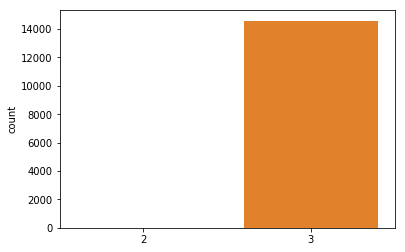

Minimum annotations in a example:  2
Maximum annotations in a example:  3
T data (expected value):  2.999041095890411
Graphics of T weights


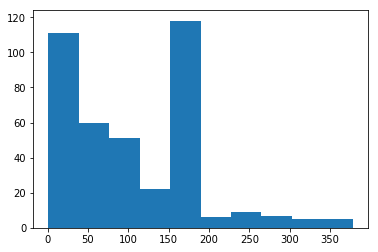

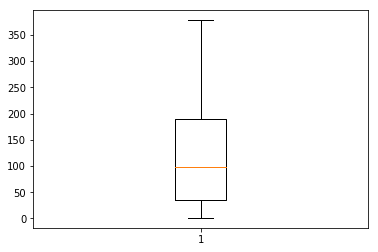

Minimum annotations by an annotator:  1
Maximum annotations by an annotator:  378
Mean annotations by an annotator:  111.13197969543147


In [45]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

#### Delta Convergence criteria

In [12]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN_text,default_CNN_text, Clonable_Model

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [14]:
#Z_train_onehot = keras.utils.to_categorical(Z_train, num_classes=Kl)
Z_test_onehot = keras.utils.to_categorical(Z_test, num_classes=Kl)

model_UB = default_RNN_text(max_L, Kl, embed_M=embedding_matrix)
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
model_UB.summary()

#hist = model_UB.fit(X_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
#print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
clone_UB = Clonable_Model(model_UB)
#Z_train_pred = model_UB.predict_classes(X_train)
#Z_test_pred = model_UB.predict_classes(X_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           1047000   
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 50, 128)           88320     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 64)                37248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                780       
Total params: 1,173,348
Trainable params: 126,348
Non-trainable params: 1,047,000
____________________________________________________________

In [26]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas, mv_conf_probas = label_I.mv_labels('probas')
mv_onehot, mv_conf_onehot = label_I.mv_labels('onehot')

Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_test_onehot = keras.utils.to_categorical(Z_test)

Representation for MV in 0.487544 sec
Representation for DS in 0.391745 sec
Estimation MV in 0.001091 sec


NameError: name 'Z_test' is not defined

In [22]:
from keras.models import Sequential,Model
from keras.layers import *
def default_CNN_text(input_dim,output_dim,embed_M=[]):
    model = Sequential() 
    if len(embed_M) != 0:
        T, R_t = embed_M.shape
        emd_layer = Embedding(T, R_t,trainable=False,weights=[embed_M],input_length=input_dim)
        model.add(emd_layer)
    else:
        model.add(InputLayer(input_shape=input_dim))
    model.add(Conv1D(128, 3, activation='relu')) #kernel 5?
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.25))
    
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.25))
    
    model.add(GlobalAveragePooling1D())
    
    #model.add(Flatten())
    #model.add(Dense(32, activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.25))
    
    model.add(Dense(output_dim, activation='softmax')) 
    return model
## muy parecida a la recurrente-.--

In [23]:
def default_RNN_text(input_dim,output_dim,embed_M=[]): 
    model = Sequential() 
    if len(embed_M) != 0:
        T, R_t = embed_M.shape
        emd_layer = Embedding(T, R_t,trainable=False,weights=[embed_M],input_length=input_dim)
        model.add(emd_layer)
    else:
        model.add(InputLayer(input_shape=input_dim))
    #model.add(Dropout(0.2))
    
    layer_gru1 = CuDNNGRU(128,return_sequences=True) #, dropout=0.2, recurrent_dropout=0.5)
    #model.add(Bidirectional(layer_gru1)) 
    model.add(layer_gru1)
    
    model.add(Dropout(0.25))
    
    layer_gru2 = CuDNNGRU(64,return_sequences=False) #, dropout=0.2, recurrent_dropout=0.5)
    #model.add(Bidirectional(layer_gru2)) #128 funciona con embd 100 (sin otra capa)
    model.add(layer_gru2) #128 funciona con embd 100 (sin otra capa)
    
    #model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    #model.add(Dense(32, activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.5))
    
    model.add(Dense(output_dim, activation='softmax'))     
    return model

In [24]:
model_UB = default_RNN_text(max_L, Kl, embed_M=embedding_matrix)
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT, metrics=["accuracy"])
model_UB.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           1046200   
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 50, 128)           88320     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 64)                37248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 1,171,963
Trainable params: 125,763
Non-trainable params: 1,046,200
____________________________________________________________

In [25]:
hist=model_UB.fit(X_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=2#,callbacks=[ourCallback]
                  ,validation_data=(X_test,Z_test_onehot))
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))

NameError: name 'Z_train_onehot' is not defined

In [ ]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

### Infer Labels (without predictive model)

In [15]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas, mv_conf_probas = label_I.mv_labels('probas')
mv_onehot, mv_conf_onehot = label_I.mv_labels('onehot')

#confe_matrix_G = get_Global_confusionM(Z_train,label_I.y_obs_repeat)

#ds_labels,ds_conf = label_I.DS_labels()

Representation for MV in 0.476145 sec
Representation for DS in 0.266179 sec
Estimation MV in 0.001486 sec


In [38]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)[mask_gt]==Z_train[mask_gt]))
#print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)[mask_gt]==Z_train[mask_gt]))

ACC MV on train: 1.0


In [27]:
model_mvsoft = clone_UB.get_model()
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT, metrics=["acc"])
hist=model_mvsoft.fit(X_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback],
                     validation_data=(X_test,Z_test_onehot))
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))
Z_train_p  = model_mvsoft.predict(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_pred = model_mvsoft.predict_classes(X_test)

Trained model over soft-MV, Epochs to converge = 5


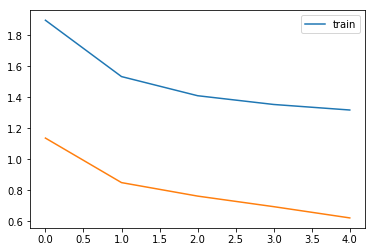

In [53]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

In [29]:
model_mvhard = clone_UB.get_model()
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(X_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))
Z_train_p = model_mvhard.predict(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_pred = model_mvhard.predict_classes(X_test)

Trained model over hard-MV, Epochs to converge = 8


In [ ]:
model_ds = clone_UB.get_model()
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(X_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))
Z_train_p = model_ds.predict(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_pred = model_ds.predict_classes(X_test)

### Raykar Model (joint predict model)

In [23]:
from code.baseline import RaykarMC
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (4999, 203, 2)


In [ ]:
raykarMC = RaykarMC(max_L, y_obs_categorical.shape[-1], T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("default rnn text", embed=embedding_matrix)

logL_hists,i_r = raykarMC.multiples_run(20,X_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

In [25]:
Z_train_p = raykarMC.get_predictions(X_train)
Z_train_pred =Z_train_p.argmax(axis=-1)
Z_test_p = raykarMC.get_predictions(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

In [ ]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Our Proposed

In [20]:
from code.MixtureofGroups import GroupMixtureGlo, GroupMixtureInd

In [21]:
""" AÑADIR A ARCHIVO GROUPS..."""
def define_uniform_groups(power, r, M):
    R_total = r.sum()
    uniform_groups = np.asarray([power*R_total/M for _ in range(M)])
    return uniform_groups

#get our representation 
r_obs = set_representation(y_obs,"repeat")
#confe_matrix_G = get_Global_confusionM(Z_train,r_obs)

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[0 3 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 2 0 ... 0 0 0]
 ...
 [0 3 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 2 0 ... 0 0 0]]
shape: (14600, 12)


There is low entropy (information), maybe there is only a few groups in this dataset, the possible of different behavior is low.

In [ ]:
gMixture_Global = GroupMixtureGlo(max_L,Kl=r_obs.shape[1],M=5,epochs=0,optimizer=OPT,dtype_op=DTYPE_OP) 

gMixture_Global.define_model("default rnn text", embed=embedding_matrix)

logL_hists,i_r = gMixture_Global.multiples_run(1,X_train,r_obs,batch_size=BATCH_SIZE,max_iter=0,tolerance=TOL)

aux = gMixture_Global.alpha_init.sum(axis=1).sum(axis=0)
plt.bar(np.arange(gMixture_Global.M),aux)
plt.show()
gMixture_Global.get_alpha()
plt.bar(np.arange(gMixture_Global.M),gMixture_Global.get_alpha())

In [22]:
M_seted = 3 #??

uniform = False
if uniform:
    uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
    print(uniform_groups)

In [23]:
gMixture_Global = GroupMixtureGlo(max_L,Kl=r_obs.shape[1],M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("default rnn text", embed=embedding_matrix)

if uniform:
    gMixture_Global.define_priors("laplace")
    gMixture_Global.define_priors(uniform_groups)

logL_hists,i_r = gMixture_Global.multiples_run(20,X_train,r_obs,
                                               batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.107678 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (14600, 12)
Betas:  (3, 12, 12)
Q estimate:  (14600, 12, 3, 12)
Iter 1/50
M step: done,  E step: done //  (in 4.71 sec)	logL: -71815.430	
Iter 2/50
M step: done,  E step: done //  (in 2.41 sec)	logL: -64280.217	Tol1: 0.10492	Tol2: 0.28361	Tol3: 0.02711	
Iter 3/50
M step: done,  E step: done //  (in 2.51 sec)	logL: -60522.812	Tol1: 0.05845	Tol2: 0.17279	Tol3: 0.03297	
Iter 4/50
M step: done,  E step: done //  (in 2.50 sec)	logL: -58095.322	Tol1: 0.04011	Tol2: 0.15824	Tol3: 0.05977	
Iter 5/50
M step: done,  E step: done //  (in 2.64 sec)	logL: -56291.948	Tol1: 0.03104	Tol2: 0.13486	Tol3: 0.03339	
Iter 6/50
M step: done,  E step: done //  (in 2.45 sec)	logL: -54443.344	Tol1: 0.03284	Tol2: 0.14039	Tol3: 0.06336	
Iter 7/50
M step: done,  E step: done //  (in 2.51 sec)	logL: -53101.231	Tol1: 0.02465	Tol2: 0.11697	Tol3: 0.05529	
Iter 8/50
M step: done,  E step:

M step: done,  E step: done //  (in 2.40 sec)	logL: -34387.890	Tol1: 0.01148	Tol2: 0.03988	Tol3: 0.09689	
Iter 33/50
M step: done,  E step: done //  (in 2.39 sec)	logL: -33906.754	Tol1: 0.01399	Tol2: 0.03373	Tol3: 0.11524	
Iter 34/50
M step: done,  E step: done //  (in 2.41 sec)	logL: -33410.789	Tol1: 0.01463	Tol2: 0.04311	Tol3: 0.09772	
Iter 35/50
M step: done,  E step: done //  (in 2.42 sec)	logL: -34858.572	Tol1: 0.04333	Tol2: 0.04198	Tol3: 0.10802	
Iter 36/50
M step: done,  E step: done //  (in 2.45 sec)	logL: -32902.625	Tol1: 0.05611	Tol2: 0.06406	Tol3: 0.05525	
Iter 37/50
M step: done,  E step: done //  (in 2.39 sec)	logL: -32779.150	Tol1: 0.00375	Tol2: 0.04835	Tol3: 0.09432	
Iter 38/50
M step: done,  E step: done //  (in 2.42 sec)	logL: -32115.746	Tol1: 0.02024	Tol2: 0.02613	Tol3: 0.08067	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.111645 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (14600, 12)
Betas:  (3, 12, 12)
Q estim

M step: done,  E step: done //  (in 2.37 sec)	logL: -39323.060	Tol1: 0.04894	Tol2: 0.10477	Tol3: 0.08693	
Iter 24/50
M step: done,  E step: done //  (in 2.37 sec)	logL: -39567.601	Tol1: 0.00622	Tol2: 0.05193	Tol3: 0.13159	
Iter 25/50
M step: done,  E step: done //  (in 2.43 sec)	logL: -37801.413	Tol1: 0.04464	Tol2: 0.06411	Tol3: 0.10225	
Iter 26/50
M step: done,  E step: done //  (in 2.43 sec)	logL: -37594.239	Tol1: 0.00548	Tol2: 0.06531	Tol3: 0.12002	
Iter 27/50
M step: done,  E step: done //  (in 2.46 sec)	logL: -37351.224	Tol1: 0.00646	Tol2: 0.08042	Tol3: 0.14463	
Iter 28/50
M step: done,  E step: done //  (in 2.43 sec)	logL: -36052.496	Tol1: 0.03477	Tol2: 0.07278	Tol3: 0.12676	
Iter 29/50
M step: done,  E step: done //  (in 2.33 sec)	logL: -35824.659	Tol1: 0.00632	Tol2: 0.05710	Tol3: 0.12876	
Iter 30/50
M step: done,  E step: done //  (in 2.39 sec)	logL: -35233.993	Tol1: 0.01649	Tol2: 0.05412	Tol3: 0.14428	
Iter 31/50
M step: done,  E step: done //  (in 2.46 sec)	logL: -35198.560	T

M step: done,  E step: done //  (in 2.44 sec)	logL: -49972.786	Tol1: 0.04169	Tol2: 0.19506	Tol3: 0.03431	
Iter 11/50
M step: done,  E step: done //  (in 2.43 sec)	logL: -49731.325	Tol1: 0.00483	Tol2: 0.10796	Tol3: 0.07982	
Iter 12/50
M step: done,  E step: done //  (in 2.44 sec)	logL: -48260.424	Tol1: 0.02958	Tol2: 0.11069	Tol3: 0.07700	
Iter 13/50
M step: done,  E step: done //  (in 2.39 sec)	logL: -47292.081	Tol1: 0.02006	Tol2: 0.09604	Tol3: 0.09340	
Iter 14/50
M step: done,  E step: done //  (in 2.41 sec)	logL: -46115.638	Tol1: 0.02488	Tol2: 0.10379	Tol3: 0.08440	
Iter 15/50
M step: done,  E step: done //  (in 2.48 sec)	logL: -45450.810	Tol1: 0.01442	Tol2: 0.07693	Tol3: 0.08725	
Iter 16/50
M step: done,  E step: done //  (in 2.38 sec)	logL: -44669.996	Tol1: 0.01718	Tol2: 0.08813	Tol3: 0.09966	
Iter 17/50
M step: done,  E step: done //  (in 2.36 sec)	logL: -43697.252	Tol1: 0.02178	Tol2: 0.12881	Tol3: 0.08255	
Iter 18/50
M step: done,  E step: done //  (in 2.40 sec)	logL: -42659.098	T

M step: done,  E step: done //  (in 2.39 sec)	logL: -32583.279	Tol1: 0.00367	Tol2: 0.04855	Tol3: 0.08468	
Iter 38/50
M step: done,  E step: done //  (in 2.44 sec)	logL: -32002.001	Tol1: 0.01784	Tol2: 0.04441	Tol3: 0.08316	
Iter 39/50
M step: done,  E step: done //  (in 2.43 sec)	logL: -31574.013	Tol1: 0.01337	Tol2: 0.03575	Tol3: 0.05986	
Iter 40/50
M step: done,  E step: done //  (in 2.46 sec)	logL: -31326.579	Tol1: 0.00784	Tol2: 0.03315	Tol3: 0.06399	
Iter 41/50
M step: done,  E step: done //  (in 2.44 sec)	logL: -31068.506	Tol1: 0.00824	Tol2: 0.03547	Tol3: 0.06900	
Iter 42/50
M step: done,  E step: done //  (in 2.44 sec)	logL: -30772.095	Tol1: 0.00954	Tol2: 0.03128	Tol3: 0.05371	
Iter 43/50
M step: done,  E step: done //  (in 2.41 sec)	logL: -30387.661	Tol1: 0.01249	Tol2: 0.03596	Tol3: 0.02373	
Iter 44/50
M step: done,  E step: done //  (in 2.44 sec)	logL: -30270.795	Tol1: 0.00385	Tol2: 0.03715	Tol3: 0.03221	
Iter 45/50
M step: done,  E step: done //  (in 2.46 sec)	logL: -30463.411	T

M step: done,  E step: done //  (in 2.46 sec)	logL: -48405.036	Tol1: 0.01614	Tol2: 0.14303	Tol3: 0.09723	
Iter 13/50
M step: done,  E step: done //  (in 2.45 sec)	logL: -47447.113	Tol1: 0.01979	Tol2: 0.12217	Tol3: 0.09070	
Iter 14/50
M step: done,  E step: done //  (in 2.42 sec)	logL: -46084.704	Tol1: 0.02871	Tol2: 0.12397	Tol3: 0.08832	
Iter 15/50
M step: done,  E step: done //  (in 2.44 sec)	logL: -45181.862	Tol1: 0.01959	Tol2: 0.08694	Tol3: 0.09109	
Iter 16/50
M step: done,  E step: done //  (in 2.40 sec)	logL: -44428.958	Tol1: 0.01666	Tol2: 0.09167	Tol3: 0.10196	
Iter 17/50
M step: done,  E step: done //  (in 2.42 sec)	logL: -43444.708	Tol1: 0.02215	Tol2: 0.09060	Tol3: 0.09909	
Iter 18/50
M step: done,  E step: done //  (in 2.38 sec)	logL: -42783.103	Tol1: 0.01523	Tol2: 0.09080	Tol3: 0.09812	
Iter 19/50
M step: done,  E step: done //  (in 2.49 sec)	logL: -41754.490	Tol1: 0.02404	Tol2: 0.08920	Tol3: 0.09483	
Iter 20/50
M step: done,  E step: done //  (in 2.43 sec)	logL: -41376.080	T

M step: done,  E step: done //  (in 2.45 sec)	logL: -30689.329	Tol1: 0.03037	Tol2: 0.03823	Tol3: 0.02828	
Iter 42/50
M step: done,  E step: done //  (in 2.42 sec)	logL: -30181.823	Tol1: 0.01654	Tol2: 0.03458	Tol3: 0.05210	
Iter 43/50
M step: done,  E step: done //  (in 2.43 sec)	logL: -30434.155	Tol1: 0.00836	Tol2: 0.01939	Tol3: 0.04028	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.111903 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (14600, 12)
Betas:  (3, 12, 12)
Q estimate:  (14600, 12, 3, 12)
Iter 1/50
M step: done,  E step: done //  (in 4.19 sec)	logL: -72932.224	
Iter 2/50
M step: done,  E step: done //  (in 2.40 sec)	logL: -64434.067	Tol1: 0.11652	Tol2: 0.23694	Tol3: 0.03807	
Iter 3/50
M step: done,  E step: done //  (in 2.42 sec)	logL: -59908.782	Tol1: 0.07023	Tol2: 0.17891	Tol3: 0.06333	
Iter 4/50
M step: done,  E step: done //  (in 2.43 sec)	logL: -57298.044	Tol1: 0.04358	Tol2: 0.14338	Tol3: 0.05228	
Iter 5/50
M step: don

M step: done,  E step: done //  (in 2.38 sec)	logL: -36015.649	Tol1: 0.00917	Tol2: 0.05271	Tol3: 0.14602	
Iter 29/50
M step: done,  E step: done //  (in 2.42 sec)	logL: -36330.642	Tol1: 0.00875	Tol2: 0.05479	Tol3: 0.13052	
Iter 30/50
M step: done,  E step: done //  (in 2.41 sec)	logL: -36151.663	Tol1: 0.00493	Tol2: 0.07531	Tol3: 0.04739	
Iter 31/50
M step: done,  E step: done //  (in 2.42 sec)	logL: -34714.168	Tol1: 0.03976	Tol2: 0.06570	Tol3: 0.10513	
Iter 32/50
M step: done,  E step: done //  (in 2.42 sec)	logL: -34054.039	Tol1: 0.01902	Tol2: 0.03802	Tol3: 0.10712	
Iter 33/50
M step: done,  E step: done //  (in 2.42 sec)	logL: -33804.120	Tol1: 0.00734	Tol2: 0.04698	Tol3: 0.12313	
Iter 34/50
M step: done,  E step: done //  (in 2.42 sec)	logL: -34633.632	Tol1: 0.02454	Tol2: 0.03968	Tol3: 0.11076	
Iter 35/50
M step: done,  E step: done //  (in 2.45 sec)	logL: -32925.874	Tol1: 0.04931	Tol2: 0.04632	Tol3: 0.08035	
Iter 36/50
M step: done,  E step: done //  (in 2.44 sec)	logL: -32971.228	T

M step: done,  E step: done //  (in 2.44 sec)	logL: -49965.505	Tol1: 0.01901	Tol2: 0.13167	Tol3: 0.06480	
Iter 11/50
M step: done,  E step: done //  (in 2.46 sec)	logL: -49256.280	Tol1: 0.01419	Tol2: 0.09330	Tol3: 0.05585	
Iter 12/50
M step: done,  E step: done //  (in 2.40 sec)	logL: -48019.423	Tol1: 0.02511	Tol2: 0.09656	Tol3: 0.07637	
Iter 13/50
M step: done,  E step: done //  (in 2.44 sec)	logL: -47667.479	Tol1: 0.00733	Tol2: 0.11988	Tol3: 0.07745	
Iter 14/50
M step: done,  E step: done //  (in 2.46 sec)	logL: -46367.060	Tol1: 0.02728	Tol2: 0.13094	Tol3: 0.11655	
Iter 15/50
M step: done,  E step: done //  (in 2.42 sec)	logL: -45358.574	Tol1: 0.02175	Tol2: 0.10720	Tol3: 0.08294	
Iter 16/50
M step: done,  E step: done //  (in 2.41 sec)	logL: -44805.408	Tol1: 0.01220	Tol2: 0.08781	Tol3: 0.09291	
Iter 17/50
M step: done,  E step: done //  (in 2.41 sec)	logL: -43860.701	Tol1: 0.02108	Tol2: 0.12578	Tol3: 0.11058	
Iter 18/50
M step: done,  E step: done //  (in 2.41 sec)	logL: -43119.377	T

M step: done,  E step: done //  (in 2.45 sec)	logL: -32909.247	Tol1: 0.02379	Tol2: 0.04812	Tol3: 0.11551	
Iter 35/50
M step: done,  E step: done //  (in 2.41 sec)	logL: -32865.720	Tol1: 0.00132	Tol2: 0.04134	Tol3: 0.09442	
Iter 36/50
M step: done,  E step: done //  (in 2.45 sec)	logL: -32493.141	Tol1: 0.01134	Tol2: 0.03341	Tol3: 0.07026	
Iter 37/50
M step: done,  E step: done //  (in 2.43 sec)	logL: -31891.743	Tol1: 0.01851	Tol2: 0.03774	Tol3: 0.05823	
Iter 38/50
M step: done,  E step: done //  (in 2.42 sec)	logL: -31746.797	Tol1: 0.00454	Tol2: 0.03398	Tol3: 0.09069	
Iter 39/50
M step: done,  E step: done //  (in 2.40 sec)	logL: -31189.102	Tol1: 0.01757	Tol2: 0.03289	Tol3: 0.05161	
Iter 40/50
M step: done,  E step: done //  (in 2.42 sec)	logL: -31461.687	Tol1: 0.00874	Tol2: 0.02959	Tol3: 0.06967	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.109248 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (14600, 12)
Betas:  (3, 12, 12)
Q estim

M step: done,  E step: done //  (in 2.38 sec)	logL: -39225.253	Tol1: 0.02235	Tol2: 0.09585	Tol3: 0.11923	
Iter 25/50
M step: done,  E step: done //  (in 2.41 sec)	logL: -38081.125	Tol1: 0.02917	Tol2: 0.06778	Tol3: 0.12352	
Iter 26/50
M step: done,  E step: done //  (in 2.46 sec)	logL: -37540.999	Tol1: 0.01418	Tol2: 0.06984	Tol3: 0.12225	
Iter 27/50
M step: done,  E step: done //  (in 2.44 sec)	logL: -36836.669	Tol1: 0.01876	Tol2: 0.04852	Tol3: 0.13328	
Iter 28/50
M step: done,  E step: done //  (in 2.45 sec)	logL: -37038.634	Tol1: 0.00548	Tol2: 0.04563	Tol3: 0.13293	
Iter 29/50
M step: done,  E step: done //  (in 2.42 sec)	logL: -36612.982	Tol1: 0.01149	Tol2: 0.07444	Tol3: 0.10842	
Iter 30/50
M step: done,  E step: done //  (in 2.40 sec)	logL: -35505.077	Tol1: 0.03026	Tol2: 0.08178	Tol3: 0.11380	
Iter 31/50
M step: done,  E step: done //  (in 2.41 sec)	logL: -35426.859	Tol1: 0.00220	Tol2: 0.06223	Tol3: 0.14132	
Iter 32/50
M step: done,  E step: done //  (in 2.41 sec)	logL: -35140.508	T

M step: done,  E step: done //  (in 2.41 sec)	logL: -50920.286	Tol1: 0.01939	Tol2: 0.11865	Tol3: 0.06033	
Iter 10/50
M step: done,  E step: done //  (in 2.41 sec)	logL: -49797.031	Tol1: 0.02206	Tol2: 0.09410	Tol3: 0.07244	
Iter 11/50
M step: done,  E step: done //  (in 2.47 sec)	logL: -48961.991	Tol1: 0.01677	Tol2: 0.08928	Tol3: 0.08724	
Iter 12/50
M step: done,  E step: done //  (in 2.41 sec)	logL: -47869.298	Tol1: 0.02232	Tol2: 0.08279	Tol3: 0.08063	
Iter 13/50
M step: done,  E step: done //  (in 2.41 sec)	logL: -47024.449	Tol1: 0.01765	Tol2: 0.08434	Tol3: 0.07899	
Iter 14/50
M step: done,  E step: done //  (in 2.42 sec)	logL: -46357.514	Tol1: 0.01418	Tol2: 0.09124	Tol3: 0.07720	
Iter 15/50
M step: done,  E step: done //  (in 2.39 sec)	logL: -45183.223	Tol1: 0.02533	Tol2: 0.11642	Tol3: 0.09311	
Iter 16/50
M step: done,  E step: done //  (in 2.38 sec)	logL: -44419.251	Tol1: 0.01691	Tol2: 0.10202	Tol3: 0.10534	
Iter 17/50
M step: done,  E step: done //  (in 2.42 sec)	logL: -43360.754	T

M step: done,  E step: done //  (in 2.41 sec)	logL: -35524.504	Tol1: 0.00274	Tol2: 0.06561	Tol3: 0.11457	
Iter 31/50
M step: done,  E step: done //  (in 2.41 sec)	logL: -35405.812	Tol1: 0.00334	Tol2: 0.07215	Tol3: 0.09480	
Iter 32/50
M step: done,  E step: done //  (in 2.42 sec)	logL: -34131.851	Tol1: 0.03598	Tol2: 0.08219	Tol3: 0.11673	
Iter 33/50
M step: done,  E step: done //  (in 2.47 sec)	logL: -33407.393	Tol1: 0.02123	Tol2: 0.06227	Tol3: 0.12911	
Iter 34/50
M step: done,  E step: done //  (in 2.41 sec)	logL: -32844.153	Tol1: 0.01686	Tol2: 0.04719	Tol3: 0.09463	
Iter 35/50
M step: done,  E step: done //  (in 2.40 sec)	logL: -32570.365	Tol1: 0.00834	Tol2: 0.03173	Tol3: 0.11191	
Iter 36/50
M step: done,  E step: done //  (in 2.40 sec)	logL: -32334.055	Tol1: 0.00726	Tol2: 0.04027	Tol3: 0.08621	
Iter 37/50
M step: done,  E step: done //  (in 2.45 sec)	logL: -32564.821	Tol1: 0.00714	Tol2: 0.03353	Tol3: 0.08312	
Iter 38/50
M step: done,  E step: done //  (in 2.42 sec)	logL: -31733.681	T

In [24]:
Z_train_p = gMixture_Global.get_predictions(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Global.get_predictions(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

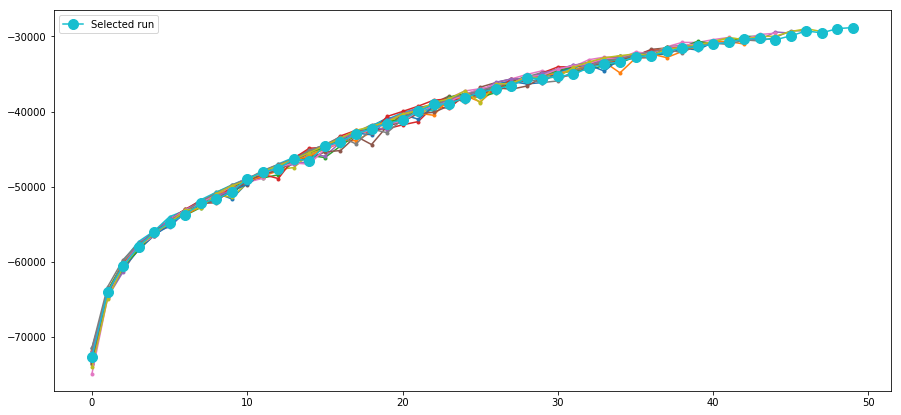

In [25]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [21]:
Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
T_idx_unique = np.arange(T).reshape(-1,1)

A = keras.utils.to_categorical(np.arange(T), num_classes=T) #fast way
print("shape of annotator representation (T, R_t)=", A.shape)

shape of annotator representation (T, R_t)= (394, 394)


shape of annotator representation (T, R_t)= (394, 3)


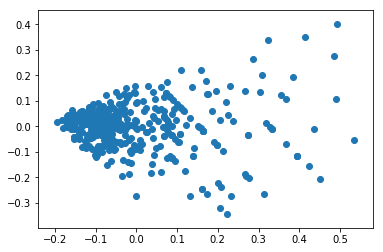

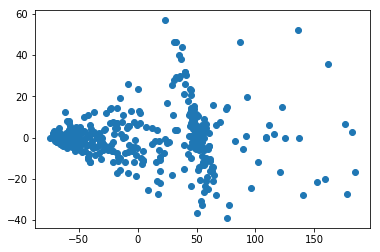

array([[127.,  24.,  38.],
       [102.,  49.,  38.],
       [135.,  98.,  26.],
       ...,
       [ 17.,   3.,   1.],
       [  8.,   5.,   1.],
       [  5.,   0.,   2.]])

In [22]:
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, r_obs.argmax(axis=-1))

#A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten
A_rep = np.zeros((conf_mat.shape[0], Kl))
for t in range(A_rep.shape[0]):
    A_rep[t] = JS_confmatrixs(conf_mat_norm[t], np.identity(Kl),raw=True) #distancia a I (MV)
    
print("shape of annotator representation (T, R_t)=", A_rep.shape)

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()


A_rep = np.zeros((y_obs.shape[1], Kl))
for i in range(N):
    for l, t_idx in enumerate(T_idx[i]):
        obs_t = Y_ann_train[i][l].argmax(axis=-1)
        A_rep[t_idx, obs_t] += 1
    
from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()
A_rep

In [23]:
#different M_seted??
M_seted = 3

In [31]:
gMixture_Ind1 = GroupMixtureInd(max_L,Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind1.define_model("default rnn text", embed=embedding_matrix)

#gMixture_Ind.define_model_group("mlp", T, M_seted, 1, BatchN=True, embed=True, embed_M=A) #con o sin BN
gMixture_Ind1.define_model_group("perceptron", T, embed=True, embed_M=A, BatchN=True,bias=False)

logL_hists,i_r = gMixture_Ind1.multiples_run(1,X_train,Y_ann_train, T_idx, A=[], batch_size=BATCH_SIZE,
                                    pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.002479 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (14600, 3)
Betas:  (3, 3, 3)
Q estimate:  (43786, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 31.49 sec)	logL: -24985.357	
Iter 2/50
M step: done,  E step: done //  (in 27.70 sec)	logL: -23007.584	Tol1: 0.07916	Tol2: 0.26617	
Iter 3/50
M step: done,  E step: done //  (in 27.50 sec)	logL: -21947.745	Tol1: 0.04606	Tol2: 0.16960	
Iter 4/50
M step: done,  E step: done //  (in 28.37 sec)	logL: -21259.809	Tol1: 0.03134	Tol2: 0.15773	
Iter 5/50
M step: done,  E step: done //  (in 26.93 sec)	logL: -20761.514	Tol1: 0.02344	Tol2: 0.18205	
Iter 6/50
M step: done,  E step: done //  (in 27.94 sec)	logL: -19810.373	Tol1: 0.04581	Tol2: 0.15533	
Iter 7/50
M step: done,  E step: done //  (in 27.66 sec)	logL: -19578.498	Tol1: 0.01170	Tol2: 0.12172	
Iter 8/50
M step: done,  E step: done

In [25]:
Z_train_p = gMixture_Ind1.get_predictions_z(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind1.get_predictions_z(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind1.get_predictions_g(T_idx_unique) 

In [ ]:
gMixture_Ind3 = GroupMixtureInd(max_L,Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind3.define_model("default rnn text", embed=embedding_matrix)

gMixture_Ind3.define_model_group("mlp", A_rep.shape[1], Kl*M_seted, 1, BatchN=False, embed=False) #con BN

logL_hists,i_r = gMixture_Ind3.multiples_run(10,X_train,Y_ann_train, T_idx, A=A_rep, batch_size=BATCH_SIZE,
                                   pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL) 

In [ ]:
Z_train_p = gMixture_Ind3.get_predictions_z(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind3.get_predictions_z(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind3.get_predictions_g(A_rep) 

In [ ]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [13]:
#Import it:
from code.evaluation import Evaluation_metrics

In [ ]:
evaluate = Evaluation_metrics(model_UB,'keras',X_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

In [28]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',X_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
#prob_Yzt = np.tile( mv_conf_probas, (T,1,1) )
prob_Yx = np.tensordot(Z_train_p, mv_conf_probas,axes=[[1],[0]])
prob_Yxt = np.tile(prob_Yx, (T,1,1)).transpose([1,0,2])

#results1 = evaluate.calculate_metrics(conf_pred=prob_Yzt,yo_pred=prob_Yxt, conf_pred_G = mv_conf_probas)

#immitate annotators
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Soft-Majority (Train with softMV) ***
Train


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


A result


,ACC imiting Annot mean,F1-mi imiting Annot mean,F1-ma imiting Annot mean,ACC imiting Annot wmean,F1-mi imiting Annot wmean,F1-ma imiting Annot wmean
0,0.5717,0.5717,0.4156,0.5822,0.5822,0.4168


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.825,0.825,0.8432


In [30]:
evaluate = Evaluation_metrics(model_mvhard,'keras',X_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yx = np.tensordot(Z_train_p, mv_conf_probas,axes=[[1],[0]])
prob_Yxt = np.tile(prob_Yx, (T,1,1)).transpose([1,0,2])

#results1 = evaluate.calculate_metrics(conf_pred=prob_Yzt,yo_pred=prob_Yxt, conf_pred_G = mv_conf_probas)

#immitate annotators
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


A result


,ACC imiting Annot mean,F1-mi imiting Annot mean,F1-ma imiting Annot mean,ACC imiting Annot wmean,F1-mi imiting Annot wmean,F1-ma imiting Annot wmean
0,0.5768,0.5768,0.4303,0.588,0.588,0.4367


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.8,0.8,0.8238


In [28]:
evaluate = Evaluation_metrics(model_ds,'keras',X_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
#results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix_R,
#                                     conf_true_G =confe_matrix_G, conf_pred_G = ds_conf.mean(axis=0))
prob_Yxt = np.tensordot(Z_train_p, ds_conf,axes=[[1],[1]])
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)


print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


A result


,ACC imiting Annot mean,F1-mi imiting Annot mean,F1-ma imiting Annot mean,ACC imiting Annot wmean,F1-mi imiting Annot wmean,F1-ma imiting Annot wmean
0,0.8082,0.8082,0.6966,0.7972,0.7972,0.7005


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.95,0.95,0.9049


In [ ]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(X_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt,conf_true_G =confe_matrix_G, conf_pred_G = prob_Yzt.mean(axis=0))

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


A result


,ACC imiting Annot mean,F1-mi imiting Annot mean,F1-ma imiting Annot mean,ACC imiting Annot wmean,F1-mi imiting Annot wmean,F1-ma imiting Annot wmean
0,0.7424,0.7424,0.6484,0.749,0.749,0.6613


Test


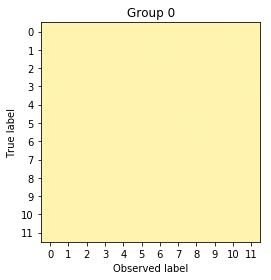

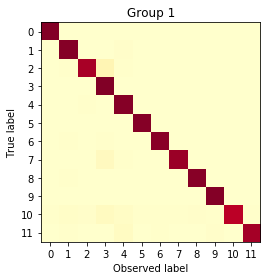

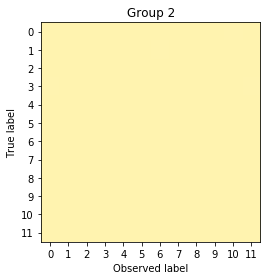

Inertia JS: 0.4692608922870131
Inertia NormF: 0.17693715740044005
A result


,Groups,Prob,T(g),Entropy,Diag mean,Isim (JS),S_raykar,S_bias,C_bias,Iner JS,Iner NormF,Accuracy,F1 (micro)
0,0,0.0001,0,2.4849,0.0840,0.2132,0.0007,0.0004,4,0.4693,0.1769,0.30,0.30
1,1,0.9999,393,0.2037,0.9632,0.9811,0.9598,0.0129,3,0.4693,0.1769,0.75,0.75
2,2,0.0001,0,2.4849,0.0840,0.2132,0.0007,0.0004,4,0.4693,0.1769,0.30,0.30


A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.75,0.75,0.5752


In [26]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(X_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(X_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(X_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs (Uniform priors) ***") #groups uniform...

print("Train")
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Ind1,'our1') 
aux = gMixture_Ind1.calculate_extra_components(X_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind1.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual-T multiples runs***")

print("Train")
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind1.get_confusionM()
y_o_groups = gMixture_Ind1.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Ind3,'our1') 
aux = gMixture_Ind3.calculate_extra_components(X_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual-K multiples runs***")

print("Train")
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind3.get_confusionM()
y_o_groups = gMixture_Ind3.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

### project confusion matrices

In [1]:
def flatten_conf(m):
    return m.reshape(m.shape[0], np.prod(m.shape[1:]))

to_plot = flatten_conf(confe_matrix_R)

centroids_plot_G = flatten_conf(gMixture_Global.get_confusionM())
centroids_plot_I2 = flatten_conf(gMixture_Ind2.get_confusionM())
centroids_plot_I3 = flatten_conf(gMixture_Ind3.get_confusionM())

from sklearn.decomposition import PCA
model = PCA(2)

to_plot = model.fit_transform(to_plot)
centroids_plot_G = model.transform(centroids_plot_G)
centroids_plot_I2 = model.transform(centroids_plot_I2)
centroids_plot_I3 = model.transform(centroids_plot_I3)

NameError: name 'confe_matrix_R' is not defined

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(to_plot[:,0], to_plot[:,1], label="Annotators")
plt.scatter(centroids_plot_G[:,0], centroids_plot_G[:,1], s=150,marker="*", color='g',label="Centroids Global")
plt.scatter(centroids_plot_I2[:,0], centroids_plot_I2[:,1],s=150, marker="X", color='magenta',label="Centroids Individual 2")
plt.scatter(centroids_plot_I3[:,0], centroids_plot_I3[:,1], s=150, marker="X", color='hotpink',label="Centroids Individual 3")

plt.legend()
plt.show()

In [ ]:
##plotear probabilidades de matriz  de conf..